As first step we read the raw matlab file as numpy array. From the info file:

Stimulation frequencies: 9, 10, 12 and 15 Hz (column 1, 2, 3 and 4 in classInfo_4_5.m)
Sampling rate: 256 Hz
CH1: sample time
CH2-9: EEG
CH10: trigger info (LED on...1, LED off...0);
CH11: LDA classification output

So:
* ch2-9 (index 1-8) is the 8 electrodes raw eeg recording
* ch10 (index 9) is the trigger channel that encode the light blinking events.


As the first step we load the raw numpy matrix in memory and then transform it in a MNE RawArray datastructure.

Make you sure to check the units! As convention, MNE expect raw data in Volt, loaded data is in micro volts!

In [1]:
def load_session(path, sampling_freq, eeg_ch_names):
    # load raw numpy data
    mat = mat73.loadmat(path)
    mat = mat['y']

    # build metadata structure
    ch_names = eeg_ch_names + ['stim1'] 
    ch_types = (['eeg'] * 8) + ['stim']
    info = mne.create_info(ch_names, sfreq=sampling_freq, ch_types=ch_types)

    mat[1:9] = mat[1:9] * 1E-6 # mne expect raw data in Volt, loaded data is in micro volts!
    raw = mne.io.RawArray(mat[1:10], info) # index 1-10 only for EEG and stim channels

    return raw

Creating RawArray with float64 data, n_channels=9, n_times=57728
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.


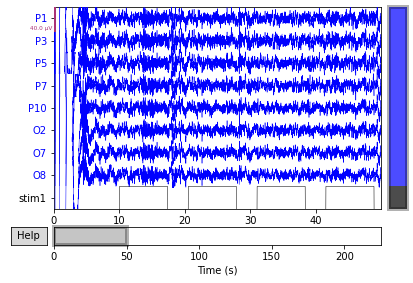

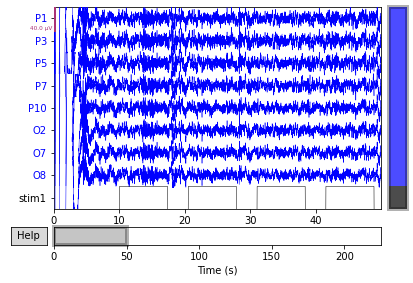

In [2]:
from pathlib import Path
import mat73
import mne


SFREQ = 256
CH_NAMES = ['P1','P3','P5','P7','P10','O2','O7','O8']
subj1_session1 = Path('ssvep/subject_1_fvep_led_training_1.mat')

raw = load_session(subj1_session1, SFREQ, CH_NAMES)

raw.plot(duration=50, color={'eeg':'blue'})

Now we must convert the raw signal (a continuous stream of data) into a segmented one. Each signal segment is a trial (mne call them Epochs).
The epoched signal is derived from the stimulus "stim" channel. The stim channel is 1 when stimul is presented to the subject, 0 otherwise (ie. is in rest state).

There is one big problem for this use case: the stim channel that we received doesn't encode which kind of stimulus is presented to the subject, in other words we don't know if when the stim channel is one, the subject is looking at 9 Hz, 10 Hz, 12 Hz or 15 Hz blinking led. 

However, we are lucky enough because the trial sequence is always the same (look at *classInfo_4_5.m* file) and we know that a single trial is 7s long. So, starting from this information, we must reconstruct a stim channel that encodes also the kind of the event.

Let's start!

As the first step we must find the events encoded in the stim channel, for this task MNE have a nice useful function called *find_events*. This function return events encoded as an array of triples:

$$ (time\_step, event\_id of previous event, event\_id) $$

Moreover we must distinguish between the onset time step and the offset time step.:
* The former is the time step when the stim channe goes from 0 to 1, ie. the event beginning
* The latter is the time step whetn the stim channle goes from 1 to 0, ie the event end.

find_event function have an output parameter that if set to "step" return both onset and offset steps.

Once we obtained this event start-end information, we must split the event in 4 sub-parts, the stim signal of each one must encode the flickering  frequency with unique event id. (just integers 1,2,3,4).

In [3]:
raw.get_data()

array([[-1.06033557e-03, -4.39110889e-03, -6.67352490e-03, ...,
        -2.11839333e-07, -1.11481071e-06, -1.45659709e-06],
       [-8.56726761e-05, -2.80387939e-04, -1.60418365e-04, ...,
        -4.29037035e-07, -1.45561612e-06, -1.32358170e-06],
       [ 1.95264771e-04,  6.47012390e-04,  3.89287079e-04, ...,
        -2.32556438e-06, -1.93242395e-06, -2.79465526e-07],
       ...,
       [-3.04575867e-04, -1.58394141e-03, -3.58679175e-03, ...,
         2.43617129e-06,  1.07023799e-06,  1.06936848e-06],
       [-6.97454468e-04, -3.07041895e-03, -5.33687256e-03, ...,
         2.22962737e-06,  1.39941478e-06,  1.74224877e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

40 events found
Event IDs: [0 1]


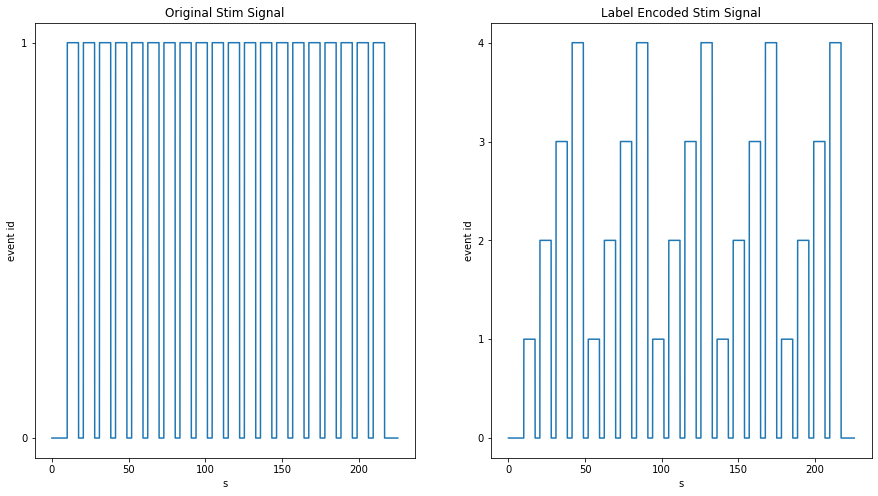

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def add_labels_to_stim(raw, n_trials=4):
    events = mne.find_events(raw, stim_channel='stim1', output='step')

    on_set_mask = events[:,2] == 1 # stim channel goes from 0 to 1
    on_set_events = events[on_set_mask, 0]

    off_set_mask = events[:,2] == 0  # stim channel goes from 1 to 0
    off_set_events = events[off_set_mask,0]

    raw_copy = raw.copy() # do not effect the original raw signal
    data = raw_copy._data # directly access the underlying numpy data!

    # loop trough events and encode the label as a stim channel event_id
    for i, (on_set, off_set) in enumerate(zip(on_set_events, off_set_events)):
        trial_label = (i % n_trials) +1 # just a trick to avoid looping i in range(1,5)
        data[8, on_set:off_set] = trial_label # modify the stim channel (index 8)

    return raw_copy

raw2 = add_labels_to_stim(raw)

orig_stim, times = raw[8]
modified_stim, times = raw2[8]
    

fig, axes = plt.subplots(ncols=2, figsize=(15,8))

axes[0].plot(times, orig_stim[0])
axes[0].set_title('Original Stim Signal')
axes[1].plot(times, modified_stim[0])
axes[1].set_title('Label Encoded Stim Signal')

for ax in axes:
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_xlabel('s')
    ax.set_ylabel('event id')


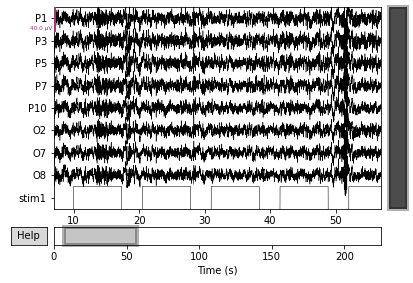

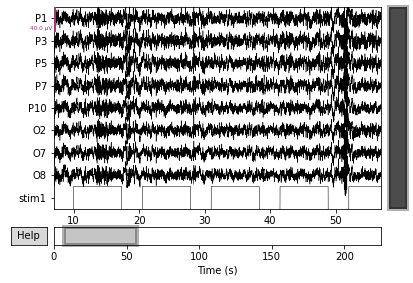

In [5]:
raw.plot(start=7, duration=50)

So we accomplish our first step. As you can see from the plot, the stim channel now encode also a different event_id for the 4 blinking frequencies
Now we can find again the events but with the corrected stim channel and build the Epoch object.

In [6]:
stim_events = {'9Hz': 1, '10Hz': 2, '12Hz': 3, '15Hz': 4}
events = mne.find_events(raw2, stim_channel='stim1')
TRIAL_DURATION = 7.35
epochs = mne.Epochs(raw, events, event_id=stim_events, tmin=-0.005, tmax=TRIAL_DURATION, picks=['eeg']) # each trial is about 7.35 s from onset stimulus 

20 events found
Event IDs: [1 2 3 4]
Not setting metadata
Not setting metadata
20 matching events found
Setting baseline interval to [-0.00390625, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [7]:
epochs.get_data().shape

Loading data for 20 events and 1884 original time points ...
0 bad epochs dropped


(20, 8, 1884)

## Data Augmentation

After we loaded the data and segmented into epochs, we can start to prepare it for the syntetic data generation step.

For each subject we have just 40 trials, uniformely distributed, so just 10 multivariate signal segment for each frequency, We need to oversample with classical time series tecniques.

We'll use *tsaug* library using simple augmenters to simulate variability :

* Time Warping: simulate variability of different pattern response to the stimulus
* Droput: this can help to simulate variability due to equipment glitches
* Drift: this can help to simulate variability accross session recordings (eg. due to subject psyco-physical state)
* Noise: just add some random additive (gaussian) noise to add variability.

Let's visualize how augmenters can affect the signal

Loading data for 20 events and 1884 original time points ...


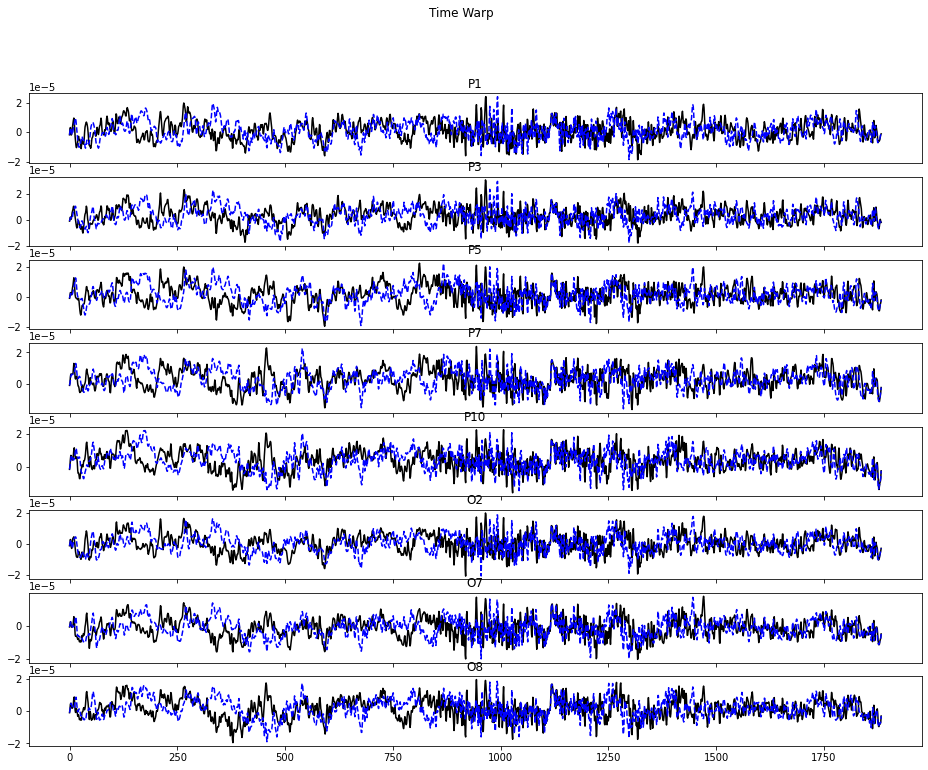

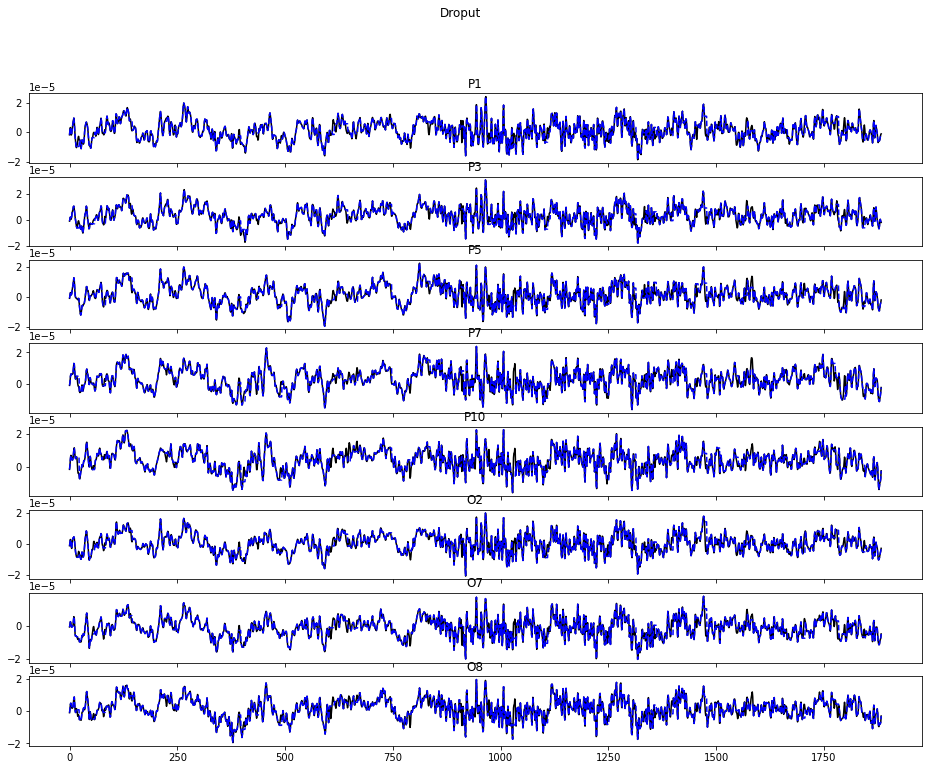

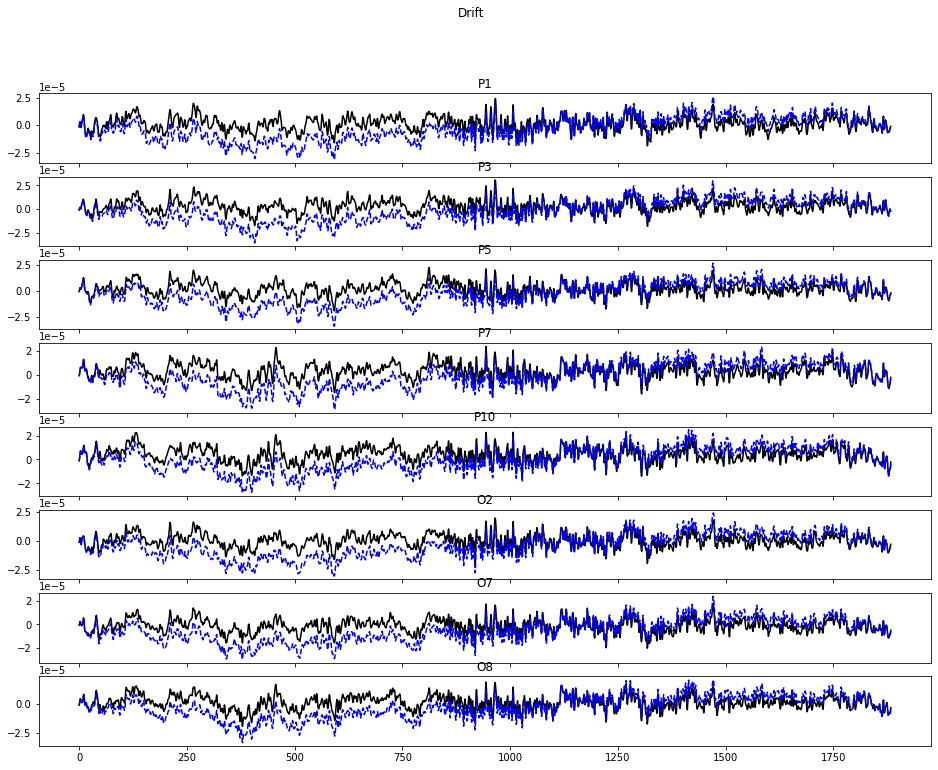

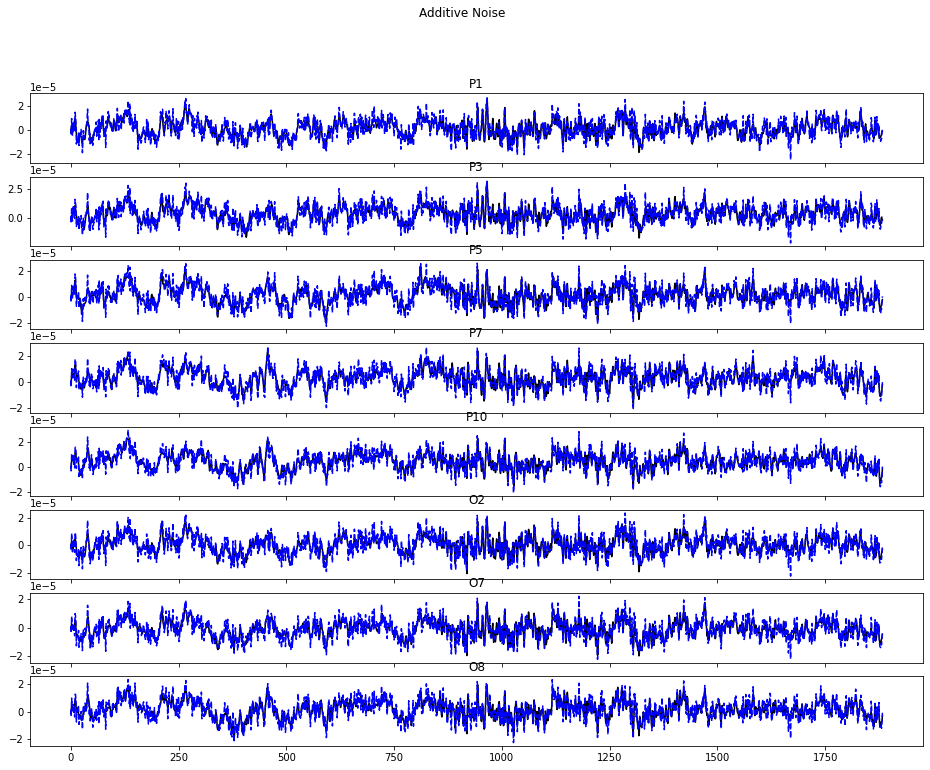

In [8]:
import tsaug
import numpy as np

def plot_augmentation(signal, augmenter, ch_names, aug_name, figsize=(16,12)):
    
    n_channels = signal.shape[0]
    fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=figsize, sharex=True)
    x = np.arange(signal.shape[1])
    
    for i, (ax,ch) in enumerate(zip(axes, signal)):
        ax.set_title(f"{ch_names[i]}")
        if i == 0: # add labels to legend just once
            ax.plot(x, ch, c='black', label=f'Original')
            ax.plot(x, augmenter.augment(ch), '--', c='blue', label=f'{aug_name}')
        else:
            ax.plot(x, ch, c='black')
            ax.plot(x, augmenter.augment(ch), '--', c='blue')

    return fig, axes


aug_seed = 1234

augmenters = [('Time Warp', tsaug.TimeWarp(n_speed_change=2, max_speed_ratio=[1.25,1.35], seed=aug_seed)),
              ('Droput', tsaug.Dropout(p=0.1, size=5, fill='ffill', per_channel=True, seed=aug_seed)),
              ('Drift', tsaug.Drift(max_drift=(.3, 0.4), n_drift_points=2, seed=aug_seed)),
              ('Additive Noise', tsaug.AddNoise(seed=aug_seed))]

trial = epochs.get_data()[0]

for name, augmenter in augmenters:
    fig, axes = plot_augmentation(trial,augmenter,ch_names=CH_NAMES, aug_name=name)
    fig.suptitle(f'{name}')


Now we can define the augmenter and preapare a new augmented dataset. Practically, for each epoch we apply the augmenter to the underlying epoch raw signal to obtain a batch of signals. The batch shape is 

> (original signal + augmented signals, # channels, # time points)

the value of augmented_signals depends on how we define the tsaug augmenter. In this case we apply 5 times the TimeWarp augmenter, 2 times the dropout and 2 times
the additive noise augmenters. So, for a single trial, we have a batch with 16 new signal plus the original one.

In [9]:

augmenter = (tsaug.TimeWarp(n_speed_change=2, max_speed_ratio=[1.25,1.35], seed=aug_seed)  * 4 +
             tsaug.Dropout(p=0.1, size=5, fill='ffill', per_channel=True, seed=aug_seed) * 2 +  
             tsaug.Drift(max_drift=(.3, 0.4), n_drift_points=2, seed=aug_seed) * 1  +
             tsaug.AddNoise(seed=aug_seed) * 2
            )

def generate_augmented_batch(trial, trial_label, augmenter):
       trialX = np.swapaxes(trial, 0,-1) # swap order for tsaug (series, time points, channels)
       trialX = trial.reshape((1,*trialX.shape)) # add batch dimension
       aug_trials = augmenter.augment(trialX) 

       all_trials = np.row_stack([trialX, aug_trials])
       all_trials = np.swapaxes(all_trials, 1,-1)

       labels = np.array([trial_label] * all_trials.shape[0])  
       return all_trials, labels

Now we apply the augmentation to each epoch and collect all generated batches into a single dataset.

In [10]:
augmenter = (tsaug.TimeWarp(n_speed_change=2, max_speed_ratio=[1.25,1.35], seed=aug_seed)  * 5 +
             tsaug.Dropout(p=0.1, size=5, fill='ffill', per_channel=True, seed=aug_seed) * 2 +  
             tsaug.Drift(max_drift=(.3, 0.4), n_drift_points=2, seed=aug_seed) * 1  +
             tsaug.AddNoise(seed=aug_seed) * 2
            )

trial_batches = []
label_batches = []            
for label in epochs.event_id.keys():
    for epoch in epochs[label]:
        aug_trials, aug_labels = generate_augmented_batch(epoch, label, augmenter)
        trial_batches.append(aug_trials)
        label_batches.append(aug_labels)

aug_trials = np.concatenate(trial_batches)
aug_labels = np.concatenate(label_batches)


In [11]:
aug_labels.shape

(420,)

# SSVEPY ANALYSIS

In [12]:
import mne
import ssvepy
# get an example data set:
from ssvepy.exampledata import epoch_example

Reading /root/venv/lib/python3.8/site-packages/ssvepy/exampledata/example-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   15996.09 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated


In [13]:
import ssvepy
from ssvepy.exampledata import epoch_example
#svep_example = ssvepy.Ssvep(epochs, [9.0,10.0,12.0,15.0], fmin=0.5, fmax=30)
ssvep_example = ssvepy.Ssvep(epoch_example, [1.2, 6.0], fmin=0.5, fmax=30)

    Using multitaper spectrum estimation with 7 DPSS windows
/root/venv/lib/python3.8/site-packages/ssvepy/ssvepyepochs.py:197: RuntimeWarning: Mean of empty slice.
  [self.psd[...,
/shared-libs/python3.8/py/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/root/venv/lib/python3.8/site-packages/ssvepy/ssvepyepochs.py:187: RuntimeWarning: Mean of empty slice.
  snr.append(self.psd[..., stimband].mean(axis=-1) /
/root/venv/lib/python3.8/site-packages/ssvepy/ssvepyepochs.py:188: RuntimeWarning: Mean of empty slice.
  self.psd[..., noiseband].mean(axis=-1))


In [14]:
ssvep_example = ssvepy.Ssvep(epoch_example, [1.2, 6.0], fmin=0.5, fmax=30)

    Using multitaper spectrum estimation with 7 DPSS windows


In [15]:
ssvep_example.plot_snr()

ValueError: cannot convert float NaN to integer

<Figure size 1080x504 with 1 Axes>

In [16]:
ssvep_example.plot_psd()

ValueError: cannot convert float NaN to integer

<Figure size 1080x504 with 1 Axes>

In [17]:
svep_example = ssvepy.Ssvep(epochs['10Hz'], [10], fmin=0.5, fmax=30)

Loading data for 5 events and 1884 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


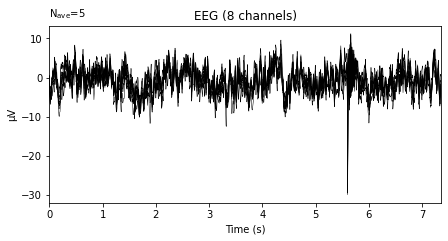

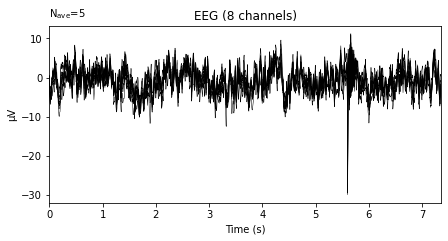

In [18]:
epochs['10Hz'].average().plot()

In [19]:
import scipy.io as io

for key in epochs.event_id.keys():
    avg = epochs[key].average()
    #print(avg.data.shape)
    io.savemat(f'averaged_epochs/avg_{key}', {'avg':avg.data})

Loading data for 20 events and 1884 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
<ipython-input-20-663aa254e021>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd(fmin = 3, fmax = 20)


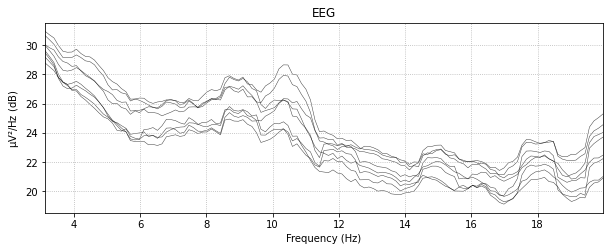

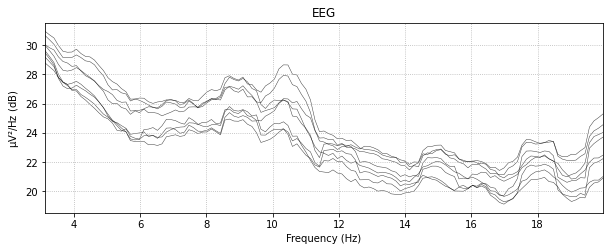

In [20]:
epochs.plot_psd(fmin = 3, fmax = 20)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b8fadf78-451d-4096-8a15-bd0880ea92ba' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>